# 本文件为真实数据拟合的PI-GRU模型，用于预测材料的力学性能。LAOS预测, 使用不同的本构模型

In [1]:
from time import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
# 导入必要的库
import xgboost as xgb
from joblib import dump

In [2]:
current_directory = os.getcwd()
print(current_directory)

# 检查是否有可用的 GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用 GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # 使用 CPU
    print("No GPU available, using CPU instead.")

/home/redfu/work/Constitutive_Equation/stress_strain_fitting/newexperiment
Using GPU: NVIDIA GeForce RTX 2080 Ti


In [3]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap
import os

# 检查系统是否安装了 Arial 字体
def is_arial_available():
    for font in fm.fontManager.ttflist:
        if 'Arial' in font.name:
            return True
    return False

# 如果系统没有 Arial 字体，加载用户自定义字体
if not is_arial_available():
    user_font_path = os.path.expanduser('~/.local/share/fonts/ARIAL.TTF')
    if os.path.exists(user_font_path):
        # 添加用户字体到 Matplotlib 的字体管理器
        fm.fontManager.addfont(user_font_path)
        # 设置 Matplotlib 使用该字体
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
        print("已加载用户自定义 Arial 字体")
    else:
        print("未找到用户自定义 Arial 字体文件")
else:
    print("系统已安装 Arial 字体")


系统已安装 Arial 字体


In [4]:
import numpy as np

def ihs_transform(data):
    """
    使用反双曲正弦变换（IHS）对数据进行对数化处理，可以直接处理负值和零值
    
    参数:
    data: ndarray, 输入数据，假设每一列是一个特征
    
    返回:
    ihs_data: ndarray, IHS变换后的数据
    """
    ihs_data = np.log(data + np.sqrt(data**2 + 1))
    return ihs_data

def inverse_ihs_transform(ihs_data):
    """
    反双曲正弦变换（IHS）的逆变换，将数据还原为原始值
    
    参数:
    ihs_data: ndarray, IHS变换后的数据
    
    返回:
    data: ndarray, 还原后的数据
    """
    data = np.sinh(ihs_data)
    return data


In [5]:
# 设置数据类型
DTYPE = torch.float32
# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

df = {}
# 读取数据
url = '../data/sx_real_data.xlsx'
df = pd.read_excel(url, sheet_name=None)
data_HF = [[k, v] for k, v in df.items()]  # k is the sheet name, v is the pandas df
# 循环遍历 data_HF 列表并获取下标
data_train=pd.DataFrame()
data_valid=pd.DataFrame()
data_special=pd.DataFrame()
for i, (sheet_name, sheet_data) in enumerate(data_HF):
    # #去除 sheet_data 中的零值
    # sheet_data = sheet_data[(sheet_data != 0).all(axis=1)]
    if i==25:
        data_valid=sheet_data
    if i==23 or i==26:
        data_train=pd.concat([data_train, sheet_data], ignore_index=True)

df_hf = pd.concat([data_train, data_valid], ignore_index=True)


In [6]:
# 创建MinMaxScaler对象
X_scaler_gamma = MinMaxScaler()
X_scaler_gammadot = MinMaxScaler()
X_scaler_gamma_0 = MinMaxScaler()
X_scaler_time = MinMaxScaler()
X_scaler_delta_t = MinMaxScaler()
y_scaler = MinMaxScaler()


# 从训练数据提取特征和标签
X_train_gamma = data_train[['gamma']].values
X_train_gammadot = data_train[['gammadot']].values
X_train_gamma_0 = data_train[['gamma_0']].values
X_train_time = data_train[['Time']].values
X_train_delta_t = data_train[['delta_t']].values
y_train_raw = data_train[['sigma']].values
# 对训练数据进行对数变换
X_train_gamma_log = ihs_transform (X_train_gamma)
X_train_gammadot_log = ihs_transform(X_train_gammadot)
X_train_gamma_0_log = ihs_transform(X_train_gamma_0)
X_train_time_log = ihs_transform(X_train_time)
X_train_delta_t_log = ihs_transform(X_train_delta_t)
y_train_raw_log = ihs_transform(y_train_raw)

# 对训练数据进行归一化并保存归一化参数
X_train_gamma_norm = X_scaler_gamma.fit_transform(X_train_gamma_log)
X_train_gammadot_norm = X_scaler_gammadot.fit_transform(X_train_gammadot_log)
X_train_gamma_0_norm = X_scaler_gamma_0.fit_transform(X_train_gamma_0_log)
X_train_time_norm = X_scaler_time.fit_transform(X_train_time_log)
X_train_delta_t_norm = X_scaler_delta_t.fit_transform(X_train_delta_t_log)
y_train_normalized = y_scaler.fit_transform(y_train_raw_log)

# 从验证数据提取特征和标签
X_valid_gamma = data_valid[['gamma']].values
X_valid_gammadot = data_valid[['gammadot']].values
X_valid_gamma_0 = data_valid[['gamma_0']].values
X_valid_time = data_valid[['Time']].values
X_valid_delta_t = data_valid[['delta_t']].values
y_valid_raw = data_valid[['sigma']].values

# 验证数据进行对数变换
X_valid_gamma_log = ihs_transform(X_valid_gamma)
X_valid_gammadot_log = ihs_transform(X_valid_gammadot)
X_valid_gamma_0_log = ihs_transform(X_valid_gamma_0)
X_valid_time_log = ihs_transform(X_valid_time)
X_valid_delta_t_log = ihs_transform(X_valid_delta_t)
y_valid_raw_log = ihs_transform(y_valid_raw)


# 使用训练数据的归一化参数对验证数据进行归一化
X_valid_gamma_norm = X_scaler_gamma.transform(X_valid_gamma_log)
X_valid_gammadot_norm = X_scaler_gammadot.transform(X_valid_gammadot_log)
X_valid_gamma_0_norm = X_scaler_gamma_0.transform(X_valid_gamma_0_log)
X_valid_time_norm = X_scaler_time.transform(X_valid_time_log)
X_valid_delta_t_norm = X_scaler_delta_t.transform(X_valid_delta_t_log)
y_valid_normalized = y_scaler.transform(y_valid_raw_log)

# 合并归一化后的特征
X_train_normalized = np.hstack((X_train_gamma_norm, X_train_gammadot_norm, X_train_gamma_0_norm))
X_valid_normalized = np.hstack((X_valid_gamma_norm, X_valid_gammadot_norm, X_valid_gamma_0_norm))

print(f"训练数据形状: X={X_train_normalized.shape}, y={y_train_normalized.shape}")
print(f"验证数据形状: X={X_valid_normalized.shape}, y={y_valid_normalized.shape}")

# 将归一化后的训练数据转换为tensor
X_data_HF = torch.tensor(X_train_normalized, dtype=torch.float32)
y_data_HF = torch.tensor(y_train_normalized, dtype=torch.float32)

# 将归一化后的验证数据转换为tensor
X_data_valid = torch.tensor(X_valid_normalized, dtype=torch.float32)
y_data_valid = torch.tensor(y_valid_normalized, dtype=torch.float32)

# 保存归一化参数
# 将scaler存入元组
scalers = (
    X_scaler_gamma,
    X_scaler_gammadot,
    X_scaler_gamma_0,
    X_scaler_time,
    X_scaler_delta_t,
    y_scaler
)

# 定义模型
in_dim, out_dim = 3, 1

训练数据形状: X=(1026, 3), y=(1026, 1)
验证数据形状: X=(513, 3), y=(513, 1)


In [7]:
# 定义时间步长
time_steps = 30

# 动态窗口实现
def create_dynamic_window(data, time_steps):
    """
    通过动态窗口将数据调整为适合 LSTM 输入的格式。
    :param data: 输入数据，形状为 (num_samples, ...)
    :param time_steps: 时间步长
    :return: 调整后的数据，形状为 (num_samples - time_steps + 1, time_steps, ...)
    """
    num_samples = data.shape[0]
    if num_samples < time_steps:
        raise ValueError("样本数量必须大于等于时间步长")
    
    # 创建动态窗口
    windowed_data = []
    for i in range(num_samples - time_steps + 1):
        window = data[i:i + time_steps]
        windowed_data.append(window)
    
    return torch.stack(windowed_data)

# 调整 X_data_HF 和 y_data_HF
# 根据 gamma_0 的值对 X_data_HF 进行分组
unique_gamma_0 = torch.unique(X_data_HF[:, 2])  # 假设 gamma_0 在第三列
grouped_X_data = []
grouped_y_data = []

for gamma_0_value in unique_gamma_0:
    # 选择当前 gamma_0 值对应的数据
    group_mask = X_data_HF[:, 2] == gamma_0_value
    group_X_data = X_data_HF[group_mask]
    group_y_data = y_data_HF[group_mask]
    
    # 对当前组数据应用动态窗口
    windowed_group_X_data = create_dynamic_window(group_X_data, time_steps)
    windowed_group_y_data = create_dynamic_window(group_y_data, time_steps)
    
    # 通常是目标值，只需要取每个窗口的最后一个时间步的值
    windowed_group_y_data = windowed_group_y_data[:, -1, :]
    
    grouped_X_data.append(windowed_group_X_data)
    grouped_y_data.append(windowed_group_y_data)

# 将所有组的数据拼接起来
X_data_HF = torch.cat(grouped_X_data, dim=0)
y_data_HF = torch.cat(grouped_y_data, dim=0)

print(X_data_HF.shape)
print(y_data_HF.shape)

torch.Size([968, 30, 3])
torch.Size([968, 1])


In [8]:
# 调整 X_data_valid
X_data_valid = create_dynamic_window(X_data_valid, time_steps)
# 调整 y_data_HF
# 注意：y_data_HF 通常是目标值，只需要取最后一个时间步的值
y_data_valid = y_data_valid[time_steps-1:]


In [9]:
class GRU_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model using GRU."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 hidden_size=20,  # GRU 隐藏层的维度
                 num_layers=4,    # GRU 层数
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(GRU_NeuralNet, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_dim = output_dim

        # 添加 GRU 层
        self.gru = nn.GRU(input_dim, hidden_size, num_layers, batch_first=True)
        
        # 添加第一层全连接层（从 GRU 的隐藏状态映射到中间层）
        self.fc1 = nn.Linear(hidden_size, hidden_size)  # 中间层的维度可以与 hidden_size 相同
        
        # 添加第二层全连接层（从中间层映射到输出维度）
        self.out = nn.Linear(hidden_size, output_dim)
        
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            for name, param in self.gru.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_normal_(param)
            nn.init.xavier_normal_(self.fc1.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            for name, param in self.gru.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):
        # GRU 输入形状: (batch_size, seq_len, input_dim)
        # GRU 输出形状: (batch_size, seq_len, hidden_size)
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(X.device)
        
        # 通过 GRU 层
        gru_out, _ = self.gru(X, h0)
        
        # 取最后一个时间步的输出
        last_time_step = gru_out[:, -1, :]  # (batch_size, hidden_size)
        
        # 通过第一层全连接层
        Z = self.fc1(last_time_step)
        
        # 应用激活函数（如果需要）
        if self.activation is not None:
            Z = self.activation(Z)
        
        # 通过第二层全连接层
        Z = self.out(Z)
        
        return Z

In [10]:
class MLP_NeuralNet(nn.Module):
    """ 设置基本的MLP模型架构。"""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 hidden_size=20,  # 隐藏层的维度
                 num_layers=4,    # 隐藏层数
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(MLP_NeuralNet, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_dim = output_dim

        # 创建层列表
        layers = []
        
        # 输入层到第一个隐藏层
        layers.append(nn.Linear(input_dim, hidden_size))
        
        # 添加激活函数
        if activation == 'tanh':
            act_func = nn.Tanh()
        elif activation == 'relu':
            act_func = nn.ReLU6()
        elif activation == 'sigmoid':
            act_func = nn.Sigmoid()
        elif activation == 'linear':
            act_func = None
        else:
            raise ValueError("不支持的激活函数")
        
        self.activation = act_func
        
        # 添加中间隐藏层
        for _ in range(num_layers - 1):
            if self.activation is not None:
                layers.append(self.activation)
            layers.append(nn.Linear(hidden_size, hidden_size))
        
        # 添加最后一层（输出层）
        if self.activation is not None:
            layers.append(self.activation)
        layers.append(nn.Linear(hidden_size, output_dim))
        
        # 创建顺序模型
        self.model = nn.Sequential(*layers)
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            for layer in self.model:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_normal_(layer.weight)
        elif kernel_initializer == 'glorot_uniform':
            for layer in self.model:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
        else:
            raise ValueError("不支持的权重初始化方法")

    def forward(self, X):
        # 只使用序列中的最后一个时间步的数据
        X_last = X[:, -1, :]  # 提取每个序列的最后一个时间步
        
        # 通过MLP模型处理最后一个时间步的数据
        Z = self.model(X_last)
        
        return Z

In [11]:
# 神经网络处理器类
class PINNSolver():

    # 类属性定义
    def __init__(self, model):
        self.model = model # 
        # Initialize history of losses and global iteration counter
        self.hist =  [[], []] # loss历史列表,0:train loss ;1:valid loss
        self.iter = 0 # 迭代次数
        self.last_n_losses = [] # 前损失列表

    # 更新损失列表   
    def update_last_n_losses(self, loss):
        self.last_n_losses.append(loss)
        if len(self.last_n_losses) > 20:
            self.last_n_losses.pop(0)

    # 计算最大相对误差        
    def ES(self):
        if len(self.last_n_losses) < 20:
            return 100  # a large number

        current_loss = self.last_n_losses[-1]
        max_relative_error = 100.*max([abs(current_loss - loss) / current_loss for loss in self.last_n_losses[:-1]])
        return max_relative_error
    
    # 计算loss，模型核心
    def loss_fn(self, X_data_HF, y_data_HF,X_data_valid,y_data_valid):
        y_pred_valid = self.model(X_data_valid)    
    
        y_pred_HF = self.model(X_data_HF)

        Loss_L2 = 1e-5 * sum(torch.sum(w_**2) for w_ in self.model.parameters())
       # 计算高频数据集的 Huber Loss
        Loss_data_HF = F.smooth_l1_loss(y_pred_HF, y_data_HF) + Loss_L2
        Loss_data_valid = F.smooth_l1_loss(y_pred_valid, y_data_valid) + Loss_L2
        return Loss_data_HF,Loss_data_valid
    
    # 训练核心函数，包括loss计算梯度计算和反向传播
    def solve_with_PyTorch_optimizer(self, optimizer, data, scheduler, batch_size, N=1001):
        """This method performs a gradient descent type optimization."""
        # 解包数据
        X_data_HF, y_data_HF, X_data_valid, y_data_valid = data

        # 创建训练数据集和 DataLoader
        train_dataset = TensorDataset(X_data_HF, y_data_HF)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        for i in range(N):
            # 初始化 epoch 的总损失
            epoch_loss_sum = 0.0
            num_batches = 0
            # 遍历每个批次
            for X_batch, y_batch in train_loader:
                # 梯度清0
                optimizer.zero_grad()
                # 计算 loss
                loss, _ = self.loss_fn(X_batch, y_batch, X_data_valid, y_data_valid)

                # 反向传播计算梯度
                loss.backward()

                # 反向传播更新权重和偏置
                optimizer.step()

                # 累加每个批次的损失
                epoch_loss_sum += loss.item()
                num_batches += 1

            # 计算 epoch 的平均损失
            # 在整个验证集上计算验证损失
            loss_train, loss_valid = self.loss_fn(X_data_HF, y_data_HF, X_data_valid, y_data_valid)

            # 记录 epoch 的平均损失
            self.current_loss = loss_train.item()
            self.valid_loss = loss_valid.item()
            # 根据 epoch 的平均损失调度学习率
            scheduler.step(loss_train)
            
            # 计算相对误差
            self.max_relative_error = self.ES()
            self.callback(self.max_relative_error, N)  # 将 max_relative_error 传递给回调函数
            self.update_last_n_losses(self.current_loss)

            # 早停机制
            if self.max_relative_error < 2e-3:  # 以 % 为单位
                print('Early stopping... \nIt {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                                                                    self.current_loss,
                                                                                                    np.round(self.max_relative_error, 3)))
                break
    # 打印loss    
    def callback(self, xr=None,N=1001):
        if self.iter % 100 == 0:
            print('It {:05,d}: Loss = {:10.4e}, Valid Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                             self.valid_loss,
                                                             np.round(self.max_relative_error, 2)))
        self.hist[0].append(self.current_loss)
        self.hist[1].append(self.valid_loss)
        self.iter+=1
    
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(8, 6),dpi=600)
            ax = fig.add_subplot(111)

        # 绘制训练集损失曲线
        ax.semilogy(range(len(self.hist[0])), self.hist[0], 'b-', label='Training Loss')
        
        # 绘制验证集损失曲线
        ax.semilogy(range(len(self.hist[1])), self.hist[1], 'g-', label='Validation Loss')

        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('Loss')
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
        ax.legend()  # 添加图例
        return ax

In [12]:
model= GRU_NeuralNet(input_dim=in_dim,
                             output_dim=out_dim,
                             num_layers=3,
                             hidden_size=30,
                             activation='relu')

# model=MLP_NeuralNet(input_dim=in_dim,
#                     output_dim=out_dim,
#                     hidden_size=30,
#                     num_layers=4,
#                     activation='relu')
# 初始化 PINNSolver
solver = PINNSolver(model)
model = model.to(device)  # 将模型移动到 GPU
X_data_HF,y_data_HF,X_data_valid,y_data_valid
# 假设 X_data_HF, y_data_HF, X_data_valid, y_data_valid 是 PyTorch 张量
X_data_HF = X_data_HF.to(device)  # 将训练集输入数据移动到 GPU
y_data_HF = y_data_HF.to(device)  # 将训练集标签数据移动到 GPU

X_data_valid = X_data_valid.to(device)  # 将验证集输入数据移动到 GPU
y_data_valid = y_data_valid.to(device)  # 将验证集标签数据移动到 GPU

In [30]:
# 定义学习率调度器
lr = 1e-2
optimizer = optim.Adam(list(model.parameters()), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
batch=484
# 定义训练模式
mode = 'PyTorch_optimizer'
N = int(5500) + 1  # 训练迭代次数

try:
    runtime
except NameError:
    runtime = 0.

if mode == 'PyTorch_optimizer':
    try:
        t0 = time()
        solver.solve_with_PyTorch_optimizer(optimizer, [X_data_HF,y_data_HF,X_data_valid,y_data_valid],scheduler,batch,N=N)
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))
    except KeyboardInterrupt:
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))

It 0,000: Loss = 1.0212e-01, Valid Loss = 1.0130e-01, Max. rel. error = 100 %


/home/redfu/anaconda3/envs/PINN/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


It 0,100: Loss = 2.0675e-03, Valid Loss = 9.1885e-03, Max. rel. error = 20.12 %
It 0,200: Loss = 1.7420e-03, Valid Loss = 9.7253e-03, Max. rel. error = 2.23 %
It 0,300: Loss = 1.6152e-03, Valid Loss = 9.6577e-03, Max. rel. error = 1.31 %
It 0,400: Loss = 1.5394e-03, Valid Loss = 9.7090e-03, Max. rel. error = 0.58 %
It 0,500: Loss = 1.4939e-03, Valid Loss = 9.6834e-03, Max. rel. error = 0.57 %
It 0,600: Loss = 1.4674e-03, Valid Loss = 9.6047e-03, Max. rel. error = 0.44 %
It 0,700: Loss = 1.4137e-03, Valid Loss = 9.5522e-03, Max. rel. error = 0.33 %
It 0,800: Loss = 1.3911e-03, Valid Loss = 9.5163e-03, Max. rel. error = 0.31 %
It 0,900: Loss = 1.3676e-03, Valid Loss = 9.4722e-03, Max. rel. error = 0.32 %
It 1,000: Loss = 1.3438e-03, Valid Loss = 9.4169e-03, Max. rel. error = 0.33 %
It 1,100: Loss = 1.3258e-03, Valid Loss = 9.3641e-03, Max. rel. error = 0.44 %
It 1,200: Loss = 1.3031e-03, Valid Loss = 9.3508e-03, Max. rel. error = 0.2 %
It 1,300: Loss = 1.2891e-03, Valid Loss = 9.3255e-03

<Axes: xlabel='$n_{epoch}$', ylabel='Loss'>

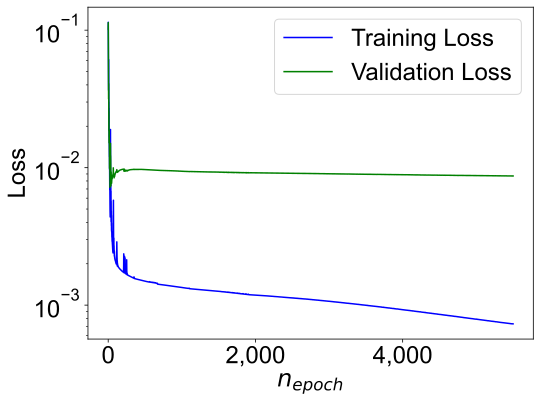

In [31]:
solver.plot_loss_history()

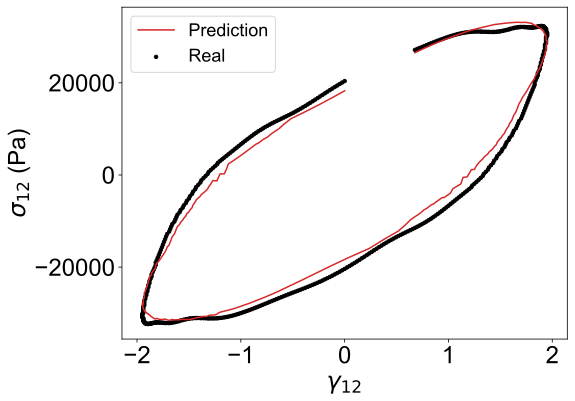

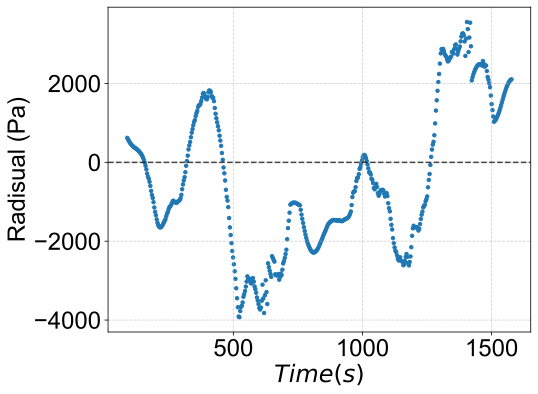


验证集评估指标:
R2 分数: 0.9934
MAE (平均绝对误差): 1675.8762
MAPE (平均绝对百分比误差): 36.4087%


In [32]:
# 统一设置字体为 Arial 24 pt
plt.rcParams['font.family'] = 'Arial'  # 设置字体为 Arial
plt.rcParams['font.size'] = 24 # 三拼图为36，单图为12最佳
model.eval()
# 颜色字典
colors = {
    'red': 'tab:red',
    'orange': 'tab:orange', 
    'yellow': '#f9c74f',
    'green': 'tab:green',
    'cyan': 'tab:cyan',
    'blue': 'tab:blue',
    'purple': 'tab:purple',
    'brown': 'tab:brown',
    'pink': 'tab:pink',
    'black': '#000000'
}

fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

# 训练集预测
y_train_pred = model(X_data_HF)
y_train_pred = y_train_pred.cpu().detach().numpy()
y_train_pred_denorm = y_scaler.inverse_transform(y_train_pred)
y_train_pred_denorm = inverse_ihs_transform(y_train_pred_denorm)
# 验证集预测  
y_valid_pred = model(X_data_valid)
y_valid_pred = y_valid_pred.cpu().detach().numpy()
y_valid_pred_denorm = y_scaler.inverse_transform(y_valid_pred)
y_valid_pred_denorm = inverse_ihs_transform(y_valid_pred_denorm)


# 绘制验证集
ax.plot(X_valid_gamma[time_steps-1:], y_valid_pred_denorm[:,0], color=colors['red'], label='Prediction')
ax.scatter(X_valid_gamma[time_steps-1:], y_valid_raw[time_steps-1:,0], color=colors['black'], marker='o', s=12, label='Real')
# 创建新的图形和坐标轴

ax.set_ylabel('$\sigma_{12}$ (Pa)')
ax.set_xlabel('$\gamma_{12}$')

# 调整图例
legend = ax.legend(fontsize=18, loc='best')
plt.show()
# 创建新的图形和坐标轴用于绘制验证集残差图
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

# 计算残差（真实值 - 预测值）
residuals = y_valid_raw[time_steps-1:, 0] - y_valid_pred_denorm[:, 0]

# 绘制残差图
ax.scatter(X_valid_time[time_steps-1:], residuals, color=colors['blue'], marker='o', s=12)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.7)  # 添加y=0的水平参考线

# 设置标签和标题
ax.set_xlabel('$Time (s)$')
ax.set_ylabel('Radisual (Pa)')

# 添加网格线以提高可读性
ax.grid(True, linestyle='--', alpha=0.6)

# 显示图形
plt.tight_layout()
plt.show()

# 定义评估指标计算函数
def calculate_metrics(y_true, y_pred):
    """
    计算R2、MAE和MAPE评估指标
    
    参数:
    y_true: 真实值
    y_pred: 预测值
    
    返回:
    包含R2、MAE和MAPE的字典
    """
    from sklearn.metrics import r2_score, mean_absolute_error
    import numpy as np
    
    # 计算R2分数
    r2 = r2_score(y_true, y_pred)
    
    # 计算MAE (平均绝对误差)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 计算MAPE (平均绝对百分比误差)
    # 避免除以零
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    return {
        'R2': r2,
        'MAE': mae,
        'MAPE': mape
    }

# 计算验证集的评估指标
valid_metrics = calculate_metrics(
    y_valid_raw[time_steps-1:, 0],  # 真实值
    y_valid_pred_denorm[:, 0]       # 预测值
)

# 打印评估指标
print("\n验证集评估指标:")
print(f"R2 分数: {valid_metrics['R2']:.4f}")
print(f"MAE (平均绝对误差): {valid_metrics['MAE']:.4f}")
print(f"MAPE (平均绝对百分比误差): {valid_metrics['MAPE']:.4f}%")



In [17]:
#torch.save(model, '../model/real/gru.pth')

### 接下来是论文绘图代码
- 主要绘制不同本构模型的对比图
- 预测值与真实值的对比图
- 残差图
- 评估指标柱状图 R2,MAE,MAPE

/tmp/ipykernel_7617/4132130309.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_maxwell=torch.load('../model/real/pigru-maxwell.pth')
/tmp/ipykernel_7617/4132130309

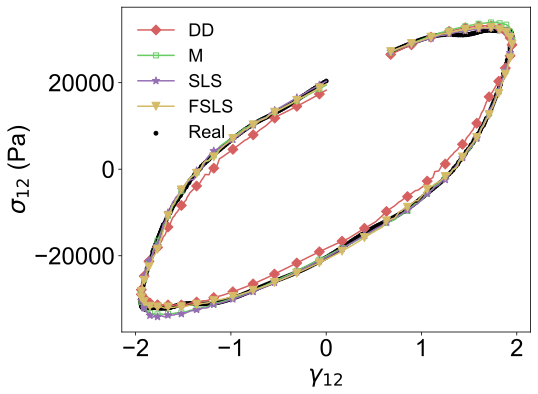

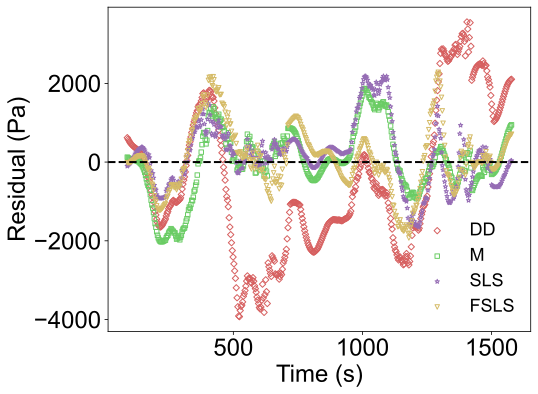

{'R2': 0.9934268626192314, 'MAE': 1675.876217624885, 'MAPE': 36.4086828602561}
{'R2': 0.9987378338852632, 'MAE': 622.1458769489319, 'MAPE': 4.317181928534661}
{'R2': 0.9988023526129461, 'MAE': 617.1584380778596, 'MAPE': 4.8686429778351314}
{'R2': 0.9987598357258785, 'MAE': 624.366664661297, 'MAPE': 4.961012816473078}


In [18]:
# 统一设置字体为 Arial 24 pt
plt.rcParams['font.family'] = 'Arial'  # 设置字体为 Arial
plt.rcParams['font.size'] = 24 # 
model_maxwell=torch.load('../model/real/pigru-maxwell.pth')
model_sls=torch.load('../model/real/pigru-sls.pth')
model_fsls=torch.load('../model/real/pigru-fsls.pth')
model_gru=torch.load('../model/real/gru.pth')  # 加载新的GRU模型
# Nature风格配色
colors = {
    'blue': '#4878D0',    # 蓝色
    'orange': '#EE854A',  # 橙色
    'green': '#6ACC64',   # 绿色
    'red': '#D65F5F',     # 红色
    'purple': '#956CB4',  # 紫色
    'brown': '#8C613C',   # 棕色
    'pink': '#DC7EC0',    # 粉色
    'gray': '#797979',    # 灰色
    'yellow': '#D5BB67',  # 黄色
    'cyan': '#82C6E2',    # 青色
    'black': '#000000'    # 黑色
}

# 定义不同的标记符号
markers = {
    'maxwell': 's',      # 方形
    'sls': '*',    # 星形，更改为与菱形差异更大的符号
    'fsls': 'v',    # 倒三角形，更改为与星形差异更大的符号
    'gru': 'D',     # 菱形，为新模型添加标记
}

# 定义评估指标计算函数
def calculate_metrics(y_true, y_pred):
    """
    计算R2、MAE和MAPE评估指标
    
    参数:
    y_true: 真实值
    y_pred: 预测值
    
    返回:
    包含R2、MAE和MAPE的字典
    """
    from sklearn.metrics import r2_score, mean_absolute_error
    import numpy as np
    
    # 计算R2分数
    r2 = r2_score(y_true, y_pred)
    
    # 计算MAE (平均绝对误差)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 计算MAPE (平均绝对百分比误差)
    # 避免除以零
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    return {
        'R2': r2,
        'MAE': mae,
        'MAPE': mape
    }

# 创建函数用于生成预测结果和评估指标
def generate_predictions_and_metrics(model, X_data, is_xgb=False):
    
    if is_xgb:
        # XGBoost模型预测
        dtest = xgb.DMatrix(X_data)
        y_pred = model.predict(dtest)
        y_pred = y_pred.reshape(-1, 1)
            # 反归一化
        y_pred_denorm = y_scaler.inverse_transform(y_pred)
        y_pred_denorm = inverse_ihs_transform(y_pred_denorm)
        metrics = calculate_metrics(
                y_valid_raw[time_steps-1:, 0],  # 真实值
                y_pred_denorm[time_steps-1:, 0]             # 预测值
            )
    else:
        # PyTorch模型预测
        model.eval()
        with torch.no_grad():
            y_pred = model(X_data)
            y_pred = y_pred.cpu().detach().numpy()

        y_pred_denorm = y_scaler.inverse_transform(y_pred)
        y_pred_denorm = inverse_ihs_transform(y_pred_denorm)
        metrics = calculate_metrics(
                y_valid_raw[time_steps-1:, 0],  # 真实值
                y_pred_denorm[:, 0]             # 预测值
            )
    
    # 计算评估指标
    return y_pred_denorm, metrics

# 生成各模型的预测结果和评估指标
y_pred_maxwell, metrics_maxwell = generate_predictions_and_metrics(model_maxwell, X_data_valid)
y_pred_sls, metrics_sls = generate_predictions_and_metrics(model_sls, X_data_valid)
y_pred_fsls, metrics_fsls = generate_predictions_and_metrics(model_fsls, X_data_valid)
y_pred_gru, metrics_gru = generate_predictions_and_metrics(model_gru, X_data_valid)  # 生成GRU模型的预测结果

# 绘制预测值-真实值对比图（所有模型在一张图上）
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

# 绘制各模型预测结果，使用不同的标记符号
ax.plot(X_valid_gamma[time_steps-1:], y_pred_gru[:, 0], color=colors['red'], marker=markers['gru'], markevery=10, markersize=7, label='DD')  # 添加GRU模型的预测结果
ax.plot(X_valid_gamma[time_steps-1:], y_pred_maxwell[:, 0], color=colors['green'], marker=markers['maxwell'], markevery=10, markersize=5, label='M',markerfacecolor='none')
ax.plot(X_valid_gamma[time_steps-1:], y_pred_sls[:, 0], color=colors['purple'], marker=markers['sls'], markevery=10, markersize=8, label='SLS')
ax.plot(X_valid_gamma[time_steps-1:], y_pred_fsls[:, 0], color=colors['yellow'], marker=markers['fsls'], markevery=10, markersize=8, label='FSLS')

ax.scatter(X_valid_gamma[time_steps-1:], y_valid_raw[time_steps-1:, 0], color=colors['black'], marker='o', s=15, label='Real')

# 设置标签和标题
ax.set_xlabel('$\gamma_{12}$')
ax.set_ylabel('$\sigma_{12}$ (Pa)')
ax.legend(fontsize=18, loc='upper left', frameon=False)

plt.tight_layout()
plt.show()


# 绘制残差对比图（所有模型在一张图上）
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

# 计算各模型残差
# residuals_xgb = y_valid_raw[time_steps-1:, 0] - y_pred_xgb[time_steps-1:, 0]
residuals_maxwell = y_valid_raw[time_steps-1:, 0] - y_pred_maxwell[:, 0]
residuals_sls = y_valid_raw[time_steps-1:, 0] - y_pred_sls[:, 0]
residuals_fsls = y_valid_raw[time_steps-1:, 0] - y_pred_fsls[:, 0]
residuals_gru = y_valid_raw[time_steps-1:, 0] - y_pred_gru[:, 0]  # 计算GRU模型的残差

# 绘制各模型残差，使用不同的标记符号
ax.scatter(X_valid_time[time_steps-1:], residuals_gru, color=colors['red'], marker=markers['gru'], s=20, label='DD',facecolor='none')  # 添加GRU模型的残差
ax.scatter(X_valid_time[time_steps-1:], residuals_maxwell, color=colors['green'], marker=markers['maxwell'], s=20, label='M',facecolor='none')
ax.scatter(X_valid_time[time_steps-1:], residuals_sls, color=colors['purple'], marker=markers['sls'], s=20, label='SLS',facecolor='none')
ax.scatter(X_valid_time[time_steps-1:], residuals_fsls, color=colors['yellow'], marker=markers['fsls'], s=20, label='FSLS',facecolor='none')

ax.axhline(y=0, color=colors['black'], linestyle='--', linewidth=2)

# 设置标签和标题
ax.set_xlabel('Time (s)')
ax.set_ylabel('Residual (Pa)')
ax.legend(fontsize=18, loc='best', frameon=False)
plt.tight_layout()
plt.show()
print(metrics_gru)  # 打印GRU模型的评估指标
print(metrics_maxwell)
print(metrics_sls)
print(metrics_fsls)


- 绘制指标柱状图



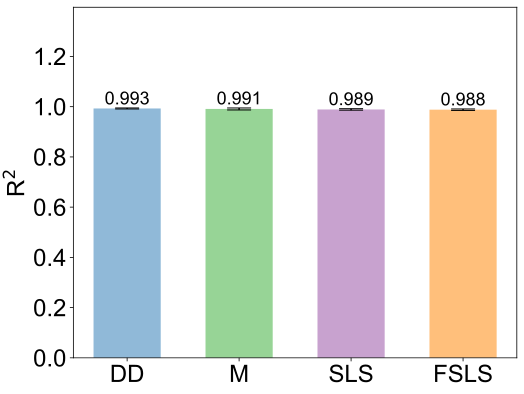

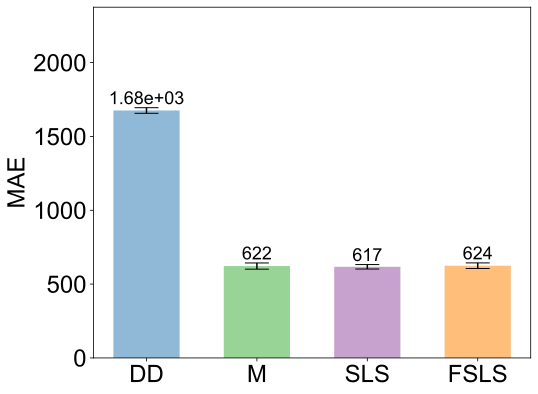

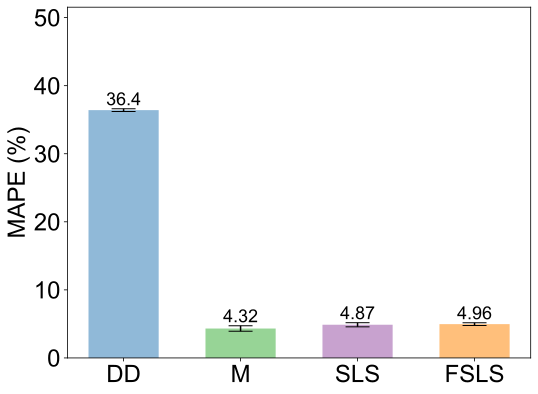

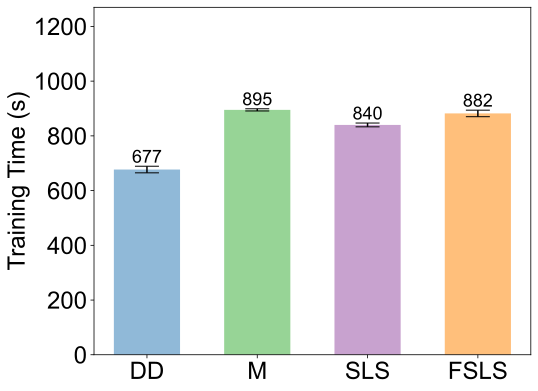

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# 设置全局字体和大小
plt.rcParams['font.family'] = 'Arial'  # 设置字体为 Arial
plt.rcParams['font.size'] = 24

# 从文件上下文中获取的实际指标数据
metrics = [f'R$^{2}$', 'MAE', 'MAPE', 'Training Time']

# 从文件上下文中提取的实际值
gru_values = [0.993, 1675.8, 36.41, 677]  # GRU (模拟训练时间)
maxwell_values = [0.991, 622.1, 4.32, 895]  # MLP (模拟训练时间)
sls_values = [0.989, 617.15, 4.87, 840]  # PI-MLP (模拟训练时间)
fsls_values = [0.988, 624.4, 4.96, 882]  # PI-GRU (模拟训练时间)

# 误差棒（模拟值）
gru_errors = [0.002, 19, 0.2, 12]
maxwell_errors = [0.004, 21, 0.4, 4]
sls_errors = [0.003, 15, 0.3, 7]
fsls_errors = [0.003, 19, 0.2, 12]

# 颜色设置
colors = {
    'gru': '#377eb8',  # 蓝色
    'maxwell': '#4daf4a',  # 绿色
    'sls': '#984ea3',  # 紫色
    'fsls': '#ff7f00'  # 黄色
}

# 自定义渐变颜色映射
def create_gradient_cmap(color1, color2, gamma=2.0, N=256):
    """
    创建渐变颜色映射
    :param color1: 渐变的起点颜色
    :param color2: 渐变的终点颜色
    :param gamma: 控制渐变的平滑度
    :param N: 渐变的分辨率
    :return: 渐变颜色映射
    """
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1, color2], N=N)
    cmap._init()
    cmap._lut[:, -1] = np.linspace(0, 1, cmap.N + 3) ** gamma  # 调整透明度
    return cmap

# 柱状图宽度
bar_width = 0.15

# 绘图
for i, metric in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=600)
    
    # 计算柱状图位置
    x = [1, 1.25, 1.5,1.75]  # 3个模型
    
    # 创建渐变颜色映射
    gru_cmap = create_gradient_cmap('lightblue', colors['gru'])
    maxwell_cmap = create_gradient_cmap('lightgreen', colors['maxwell'])
    sls_cmap = create_gradient_cmap('lavender', colors['sls'])
    fsls_cmap = create_gradient_cmap('lightyellow', colors['fsls'])
    
    # 绘制柱状图
    gru_bar = ax.bar(x[0], gru_values[i], width=bar_width, color=gru_cmap(0.8), 
                    yerr=gru_errors[i], capsize=12, label='DD')
    maxwell_bar = ax.bar(x[1], maxwell_values[i], width=bar_width, color=maxwell_cmap(0.8), 
                      yerr=maxwell_errors[i], capsize=12, label='M')
    sls_bar = ax.bar(x[2], sls_values[i], width=bar_width, color=sls_cmap(0.8), 
                      yerr=sls_errors[i], capsize=12, label='SLS')
    fsls_bar = ax.bar(x[3], fsls_values[i], width=bar_width, color=fsls_cmap(0.8), 
                      yerr=fsls_errors[i], capsize=12, label='FSLS')
    
    # 显示柱状图数字（格式化为三位有效数字的字符串）
    for bar, value, error in zip([gru_bar, maxwell_bar, sls_bar, fsls_bar], 
                               [gru_values[i], maxwell_values[i], sls_values[i], fsls_values[i]],
                               [gru_errors[i], maxwell_errors[i], sls_errors[i], fsls_errors[i]]):
        for rect in bar:
            height = rect.get_height()
            # 将数值显示在柱状图顶部 + 误差值的位置
            ax.text(
                rect.get_x() + rect.get_width() / 2.0,  # x 位置：柱状图中心
                height + error,  # y 位置：柱状图高度 + 误差值
                f'{value:.3g}',  # 显示的数值，三位有效数字
                ha='center',  # 水平居中
                va='bottom',  # 垂直对齐到底部
                fontsize=18
            )
    
    # 设置y轴标签
    if i == 3:
        ax.set_ylabel(metric + ' (s)')
    elif i == 2:
        ax.set_ylabel(metric + ' (%)')
    else:
        ax.set_ylabel(metric)
    
    ax.set_xticks(x)
    ax.set_xticklabels(['DD', 'M', 'SLS', 'FSLS'])  # x轴标签
    
    # 调整y轴范围，留出更多空白
    max_value = max(gru_values[i], maxwell_values[i], sls_values[i], fsls_values[i])
    max_with_error = max_value + max([gru_errors[i], maxwell_errors[i], sls_errors[i], fsls_errors[i]])
    ax.set_ylim(0, max_with_error * 1.4)  # 设置y轴上限
    

    
    # 调整布局
    plt.tight_layout()
    
    # 显示图形
    plt.show()

- 绘制算法雷达图

FileNotFoundError: [Errno 2] No such file or directory: 'pic/leida-laos.pdf'

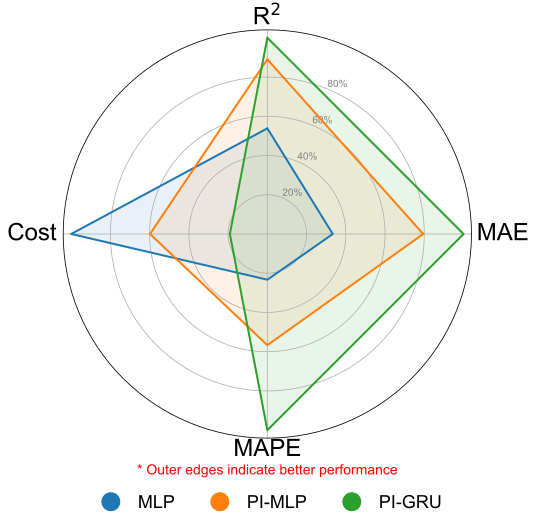

In [20]:


# =============== 数据预处理 ===============
metrics = ['R$^2$', 'MAE', 'MAPE', 'Cost']
models = {
  'MLP' : [0.949, 4206.4, 47.02, 450],  # MLP (模拟训练时间)
  'PI-MLP' : [0.981, 1728.2, 28.44, 671] , # PI-MLP (模拟训练时间)
  'PI-GRU' : [0.991, 622.1, 4.32, 895] ,
  'baseline1':[0.9,6000,60,1000] # PI-GRU (模拟训练时间)
}

# 标准化处理（R²和训练时间正向指标，MAE/MAPE负向指标）
def normalize(data, reverse=False):
    min_val = min(data)
    max_val = max(data)
    scaled = [(x - min_val)/(max_val - min_val) for x in data]
    return [1-x for x in scaled] if reverse else scaled

# 处理各指标
r2 = normalize([v[0] for v in models.values()])  # 正向指标
mae = normalize([v[1] for v in models.values()], reverse=True)  # 负向指标反向处理
mape = normalize([v[2] for v in models.values()], reverse=True)
train_time = normalize([v[3] for v in models.values()],reverse=True)  # 负向指标

# =============== 雷达图绘制 ===============
# 角度计算（闭合处理）
num_vars = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 闭合多边形

# 创建画布
plt.figure(figsize=(8, 8), dpi=600,facecolor='none')
ax = plt.subplot(111, polar=True)
ax.patch.set_alpha(0) # 设置子图背景透明
# 颜色配置（参考网页1的配色方案）
colors = {
    'MLP': '#1f77b4',
    'PI-MLP': '#ff7f0e',
    'PI-GRU': '#2ca02c'
}


# 绘制每个模型
for model, color in colors.items():
    values = []
    if model == 'MLP': values = [r2[0], mae[0], mape[0], train_time[0]]
    elif model == 'PI-MLP': values = [r2[1], mae[1], mape[1], train_time[1]]
    elif model == 'PI-GRU': values = [r2[2], mae[2], mape[2], train_time[2]]
    
    # 数据闭合处理（参考网页3）
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, label=model)
    ax.fill(angles, values, color=color, alpha=0.1)

# =============== 坐标轴设置 ===============
# 标签设置（参考网页5）
ax.set_theta_offset(np.pi/2)  # 起始角度在顶部
ax.set_theta_direction(-1)   # 顺时针方向
ax.set_xticks(angles[:-1])

# 调整标签位置，避免与雷达图外围线交叉
label_positions = {
    'R$^2$': [0, 1.1],
    'MAE': [np.pi/2, 1.2],  # 向外移动MAE标签
    'MAPE': [np.pi, 1.1],
    'Cost': [3*np.pi/2, 1.2]  # 向外移动Cost标签
}

for label, (angle, distance) in zip(metrics, label_positions.values()):
    ax.text(angle, distance, label, 
            ha='center', va='center', 
            fontsize=24)

# 隐藏默认标签
ax.set_xticklabels([])

# 径向网格线（参考网页10）
ax.set_rgrids([0.2, 0.4, 0.6, 0.8], 
              labels=['20%', '40%', '60%', '80%'],
              fontsize=10,
              color='grey')

# =============== 图例与标题 ===============
# 使用自定义图例，放在图表下方，分两行显示
# =============== 修改后的图例部分 ===============
# 创建图例元素（保持原有代码）
legend_elements = []
for model, color in colors.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=color, markersize=20, label=model))

# 单行图例设置
legend = ax.legend(
    handles=legend_elements,
    loc='upper center',          # 基准定位点
    bbox_to_anchor=(0.5, -0.1),  # 纵向位置调整（更靠近图表）
    ncol=len(colors),            # 列数=模型数量（3）
    frameon=False,               # 保持无边框
    fontsize=18,
    handletextpad=0.5,           # 标签与图标间距
    columnspacing=1.5            # 列间间距
)
# 添加注释文本
note_text = "* Outer edges indicate better performance"
ax.text(0.5, -0.08, note_text, fontsize=14, color='red', ha='center', va='center', transform=ax.transAxes)


# =============== 输出图像 ===============
plt.tight_layout()
plt.savefig('pic/leida-laos.pdf', bbox_inches='tight',transparent=True)  # 矢量格式输出（参考网页7）
plt.show()
# =============== 方案三：极坐标辅助刻度系统 ===============
# 理论最优值配置（标准化后的最优值为1）

